In [333]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [334]:
#Load Images
DIFF_DIREC = os.getcwd()+"/crop_image/diff"
NOR_DIREC = os.getcwd()+"/crop_image/nor"
DISP_DIREC = os.getcwd()+"/crop_image/disp"
x_data = os.listdir(DIFF_DIREC)
y_data = os.listdir(NOR_DIREC)

In [335]:
import re

def find_label(name, img_list):
    for img in img_list:
        x = re.search("^\w+[_]",name) 
        y = re.search("^\w+[_]", img)
        if x.group() == y.group() :
            return img
    return None

In [336]:
from PIL import Image
def JPGtoNumpy(image_path):
    image = Image.open(image_path)
    image.load()
    data = np.asarray(image, dtype=np.float32)
    data = data.reshape((3,256,256))
    return data

In [89]:
x = [JPGtoNumpy(DIFF_DIREC+"/"+x) for x in x_data[:-3]]
y = [JPGtoNumpy(NOR_DIREC+"/"+find_label(x,y_data)) for x in x_data[:-3]]

In [97]:
sample_x = torch.Tensor(JPGtoNumpy(DIFF_DIREC+"/"+x_data[-1])).view(-1,3,256,256)

In [90]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(x)
tensor_y = torch.Tensor(y)

dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(dataset, batch_size = 32)

In [337]:
class myDataset(Dataset):
    def __init__(self,diff_dir, nor_dir, transform=None):
        self.colorDir = diff_dir
        self.norDir = nor_dir
        self.transform =transform
    def __len__(self):
        return len(os.listdir(self.colorDir))
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x_data = os.listdir(self.colorDir)
        y_data = os.listdir(self.norDir)
        color = Image.open(self.colorDir+"/"+x_data[idx])
        normal = Image.open(self.norDir+"/"+find_label(x_data[idx],y_data))
        if self.transform:
            color = self.transform(color)
            normal = data_transform(normal)
        return color,normal

In [411]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [412]:
dataset = myDataset(diff_dir = DIFF_DIREC, nor_dir=NOR_DIREC, transform=data_transform)
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

torch.Size([32, 3, 256, 256])


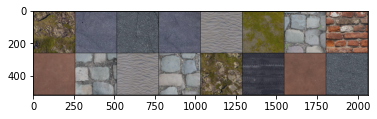

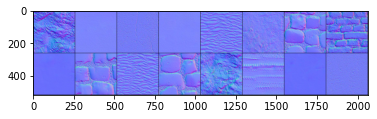

In [413]:
real_batch, real_2 = next(iter(dataloader))
print(real_batch.shape)
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(real_batch[0:16].to(device), normalize=True).cpu(),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(real_2[0:16].to(device), normalize=True).cpu(),(1,2,0)))

In [414]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle =True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [415]:
from network import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss().to(device)


In [420]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    loss2 = 0
    for x,y in train_dataloader:
        x= x.to(device)
        y= y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        
        train_loss = criterion(outputs, y)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    for x,y in test_dataloader:
        x= x.to(device)
        y= y.to(device)
        outputs = model(x)
        test_loss = criterion(outputs, y)
        loss2 += test_loss.item() 
        
    loss = loss / len(train_dataloader)
    loss2 = loss2 / len(test_dataloader)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, testloss = {:.6f}".format(epoch + 1, epochs, loss,loss2))

epoch : 1/20, loss = 0.233320, testloss = 0.236063
epoch : 2/20, loss = 0.228672, testloss = 0.198005
epoch : 3/20, loss = 0.225467, testloss = 0.243755
epoch : 4/20, loss = 0.218465, testloss = 0.194902
epoch : 5/20, loss = 0.215984, testloss = 0.230292
epoch : 6/20, loss = 0.213484, testloss = 0.187728
epoch : 7/20, loss = 0.211217, testloss = 0.219039
epoch : 8/20, loss = 0.211643, testloss = 0.223319
epoch : 9/20, loss = 0.205615, testloss = 0.191585
epoch : 10/20, loss = 0.204422, testloss = 0.214049
epoch : 11/20, loss = 0.203567, testloss = 0.197310
epoch : 12/20, loss = 0.199545, testloss = 0.199793
epoch : 13/20, loss = 0.196823, testloss = 0.186201
epoch : 14/20, loss = 0.195871, testloss = 0.200819
epoch : 15/20, loss = 0.194838, testloss = 0.213866
epoch : 16/20, loss = 0.191648, testloss = 0.210783
epoch : 17/20, loss = 0.188028, testloss = 0.194946
epoch : 18/20, loss = 0.189790, testloss = 0.177114
epoch : 19/20, loss = 0.184294, testloss = 0.202108
epoch : 20/20, loss =

In [424]:
sample_x, sample_y = next(iter(test_dataloader))
out = model(sample_x.to(device))

In [425]:
out.shape

torch.Size([32, 3, 256, 256])

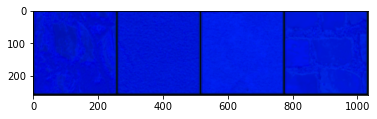

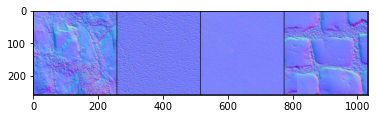

In [426]:
import torchvision.utils as vutils
out = out.detach().cpu()
out_img = np.transpose(vutils.make_grid(out[0:4], normalize=True),(1,2,0))
plt.imshow(out_img)
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(sample_y[0:4], normalize=True),(1,2,0)))